<a href="https://colab.research.google.com/github/NandakumarGunalan/MLLaboratory/blob/main/Copy_of_lec_5_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

from plotnine import *

my_theme creates a custom Plotnine theme to control how your plots look. It sets the figure size, removes gridlines, adjusts font sizes for axis labels and tick marks, sets a clean white background, and customizes the legend (direction, position, text size, and background). The function returns this theme so you can apply it to any plot to keep a consistent, clean style.

In [ ]:
def my_theme(font_size: int = 16,
             figure_size: list = [8, 6],
             legend_position: str = 'top') -> theme:
  th = theme_bw()
  th += theme(
    figure_size = figure_size,
    panel_grid = element_blank(),
    axis_title = element_text(size = font_size, family = 'sans'),
    axis_text = element_text(size = font_size, family = 'sans'),
    strip_text = element_text(size = font_size, family = 'sans'),
    strip_background = element_rect(fill = 'white'),
    legend_direction = 'vertical',
    legend_position = legend_position,
    legend_title = element_blank(),
    legend_text = element_text(size = font_size),
    legend_background = element_rect(fill = 'white')
  )
  return th

This code generates a synthetic dataset, trains a logistic regression model using 5-fold cross-validation, and calculates the mean accuracy to evaluate the model.

In [ ]:
# Generate some data
np.random.seed(8675309)

X = np.random.randn(10000, 2)
y = np.where(X[:, 0] + X[:, 1] > 0, 1, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a logistic regression classifier
classifier = LogisticRegression()

# Create an empty list to store the accuracies
accuracies = []

# Create a KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Train the classifier and calculate the accuracy for each split
for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    classifier.fit(X_train_fold, y_train_fold)
    predictions = classifier.predict(X_test_fold)

    accuracy = accuracy_score(y_test_fold, predictions)
    accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = np.mean(accuracies)

This code plots the accuracy for each fold from 5-fold cross-validation. Points and a line show fold accuracies, while a dashed horizontal line and label indicate the mean accuracy. The custom theme is applied for a clean, readable plot.

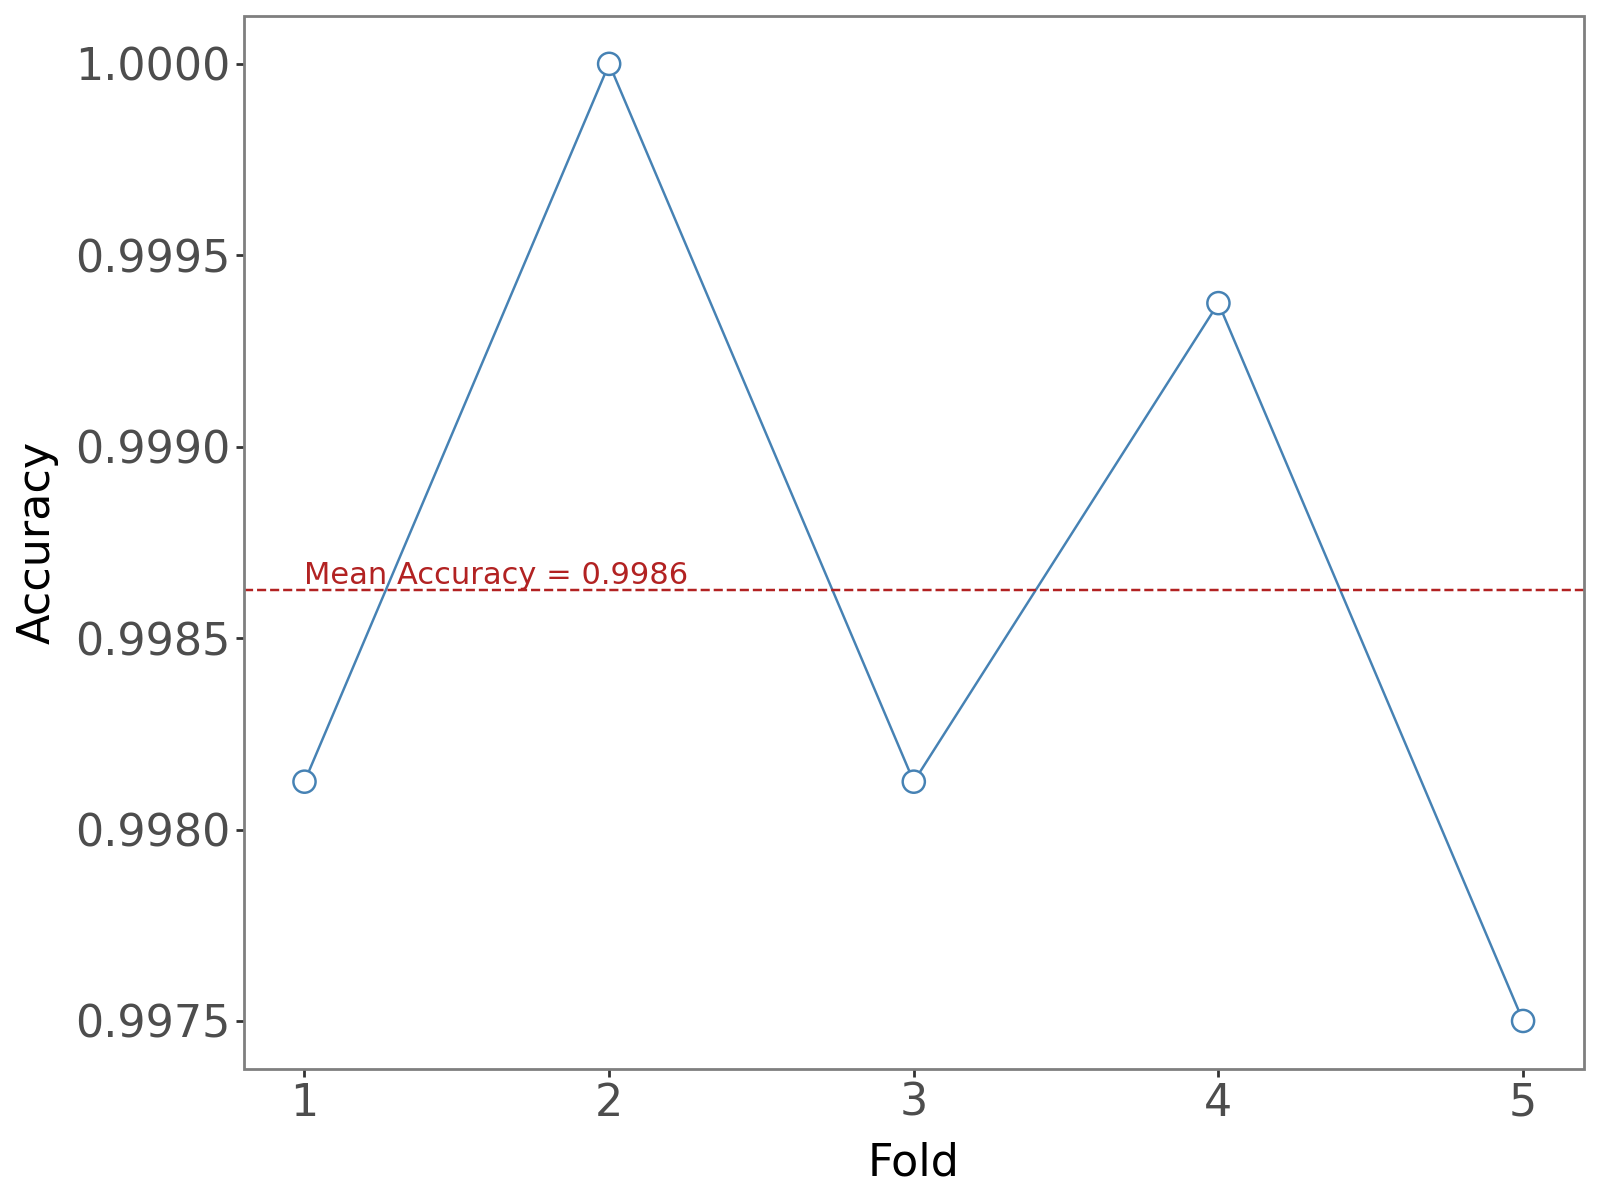

In [ ]:
accuracies_data = pd.DataFrame({
    'fold': np.arange(len(accuracies)) + 1, 'accuracies': accuracies
})

mean_accuracy_label = pd.DataFrame({
    'x': [1],
    'y': [mean_accuracy],
    'label': ['Mean Accuracy = ' + '{:.4f}'.format(mean_accuracy)]
})

(
    ggplot(accuracies_data, aes(x = 'fold', y = 'accuracies')) +
      geom_line(color = 'steelblue') +
      geom_point(color = 'steelblue', fill = 'white', size = 4) +
      geom_hline(
          yintercept = mean_accuracy,
          color = 'firebrick',
          linetype = 'dashed') +
      geom_text(
          aes(x = 'x', y = 'y', label = 'label'),
          data = mean_accuracy_label,
          ha = 'left',
          va = 'bottom',
          color = 'firebrick') +
      my_theme() +
      labs(x = 'Fold', y = 'Accuracy')
)

check how the classifier’s accuracy changes when varying the threshold for converting predicted probabilities into class labels. It can be used to find the threshold that maximizes accuracy.

In [ ]:
def accuracy_score_threshold(y: np.array,
                             yhat: np.array,
                             threshold: float = 0.5) -> float:
  # Apply a threshold to the predicted probabilities
  y_pred = (yhat[:, 1] >= threshold).astype('int')

  # Calculate the accuracy
  return accuracy_score(y, y_pred)

y_pred_proba = classifier.predict_proba(X_test)

thresholds = np.arange(0, 1, 0.001)[1:]
acc = [accuracy_score_threshold(y_test, y_pred_proba, t) for t in thresholds]

visualizes how accuracy changes with different probability thresholds and highlights the threshold that maximizes accuracy on the test set.

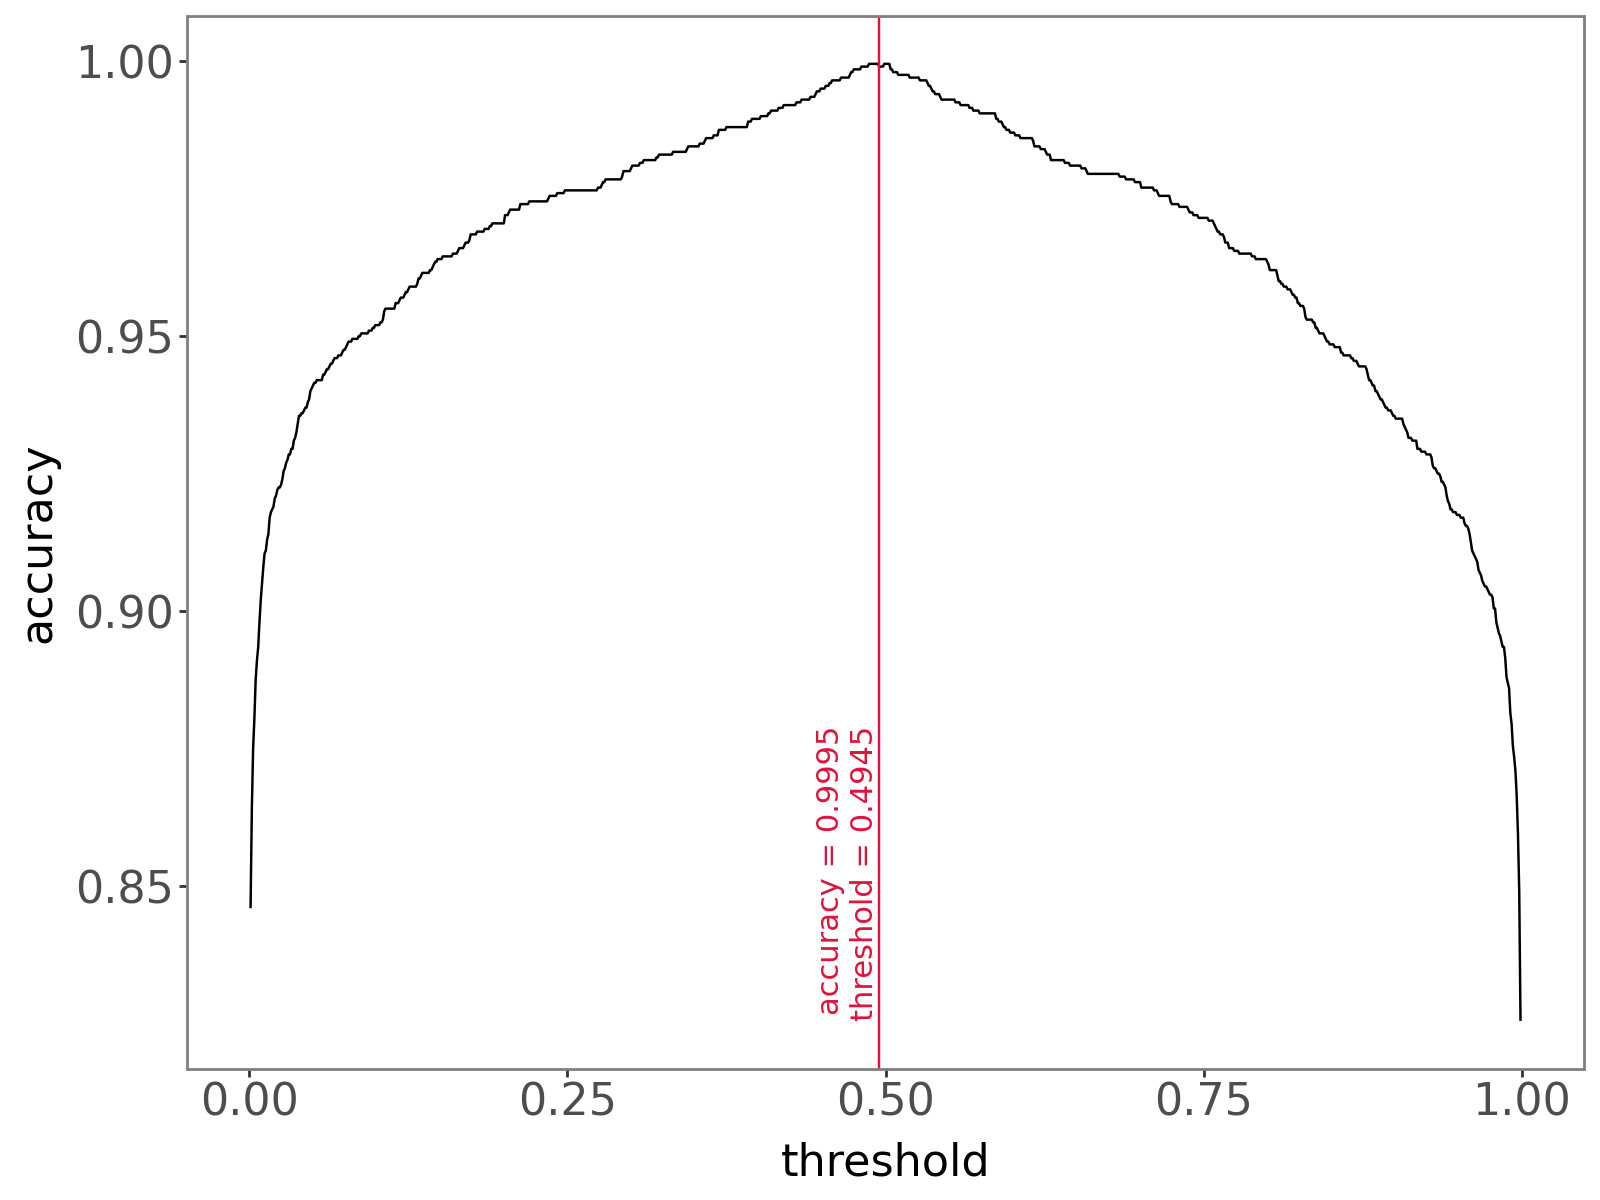

In [ ]:
acc_data = pd.DataFrame({'x': thresholds, 'y': acc})
max_acc_data = (
    acc_data[acc_data['y'] == acc_data['y'].max()]
      .mean()
      .reset_index()
      .set_index('index')
      .T
      .pipe(lambda p: p.assign(
          label_x = np.round(p.x, 4),
          label_y = np.round(p.y, 4)
      ))
      .pipe(lambda p: p.assign(
          label = f'accuracy = {p.label_y[0]}\nthreshold = {p.label_x[0]}',
          y = np.min(acc_data['y'])
      ))
)

(
    ggplot(acc_data, aes(x = 'x', y = 'y')) +
      geom_line() +
      my_theme() +
      labs(x = 'threshold', y = 'accuracy') +
      geom_vline(xintercept = max_acc_data['x'].values[0], color = 'crimson') +
      geom_text(aes(x = 'x', y = 'y', label = 'label'),
                data = max_acc_data,
                angle = 90, va = 'bottom', ha = 'right',
                color = 'crimson')
)

visualizes how accuracy changes with different probability thresholds and highlights the threshold that maximizes accuracy on the test set.

This code calculates the ROC AUC for a set of predictions. fpr and tpr are the false-positive and true-positive rates across thresholds. auc is the AUC for the model predictions, while auc_constant is the AUC for a baseline constant predictor (using the mean of actual labels). Comparing the two shows how much better the model is than a naive constant predictor.

In [ ]:
actual = np.array([1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])
pred_label = np.array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0])
predicted = np.array([0.8, 0.9, 0.2, 0.6, 0.3, 0.1, 0.7, 0.6, 0.6, 0.1, 0.1, 0.2, 0.4, 0.5, 0.1])
constant = np.repeat(np.mean(actual), len(actual))

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(actual, predicted)

auc = roc_auc_score(actual, predicted)
auc_constant = roc_auc_score(actual, constant)

auc, auc_constant

(0.9199999999999999, 0.5)

In [ ]:
thresholds

array([1.9, 0.9, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])

In [ ]:
roc = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc

,fpr,tpr
0,0.0,0.0
1,0.0,0.2
2,0.0,0.6
3,0.2,0.8
4,0.3,0.8
5,0.3,1.0
6,0.4,1.0
7,0.6,1.0
8,1.0,1.0


This code plots the ROC curve, showing True Positive Rate vs. False Positive Rate. It includes a diagonal reference line for random guessing and applies a custom theme for a clean, square plot.

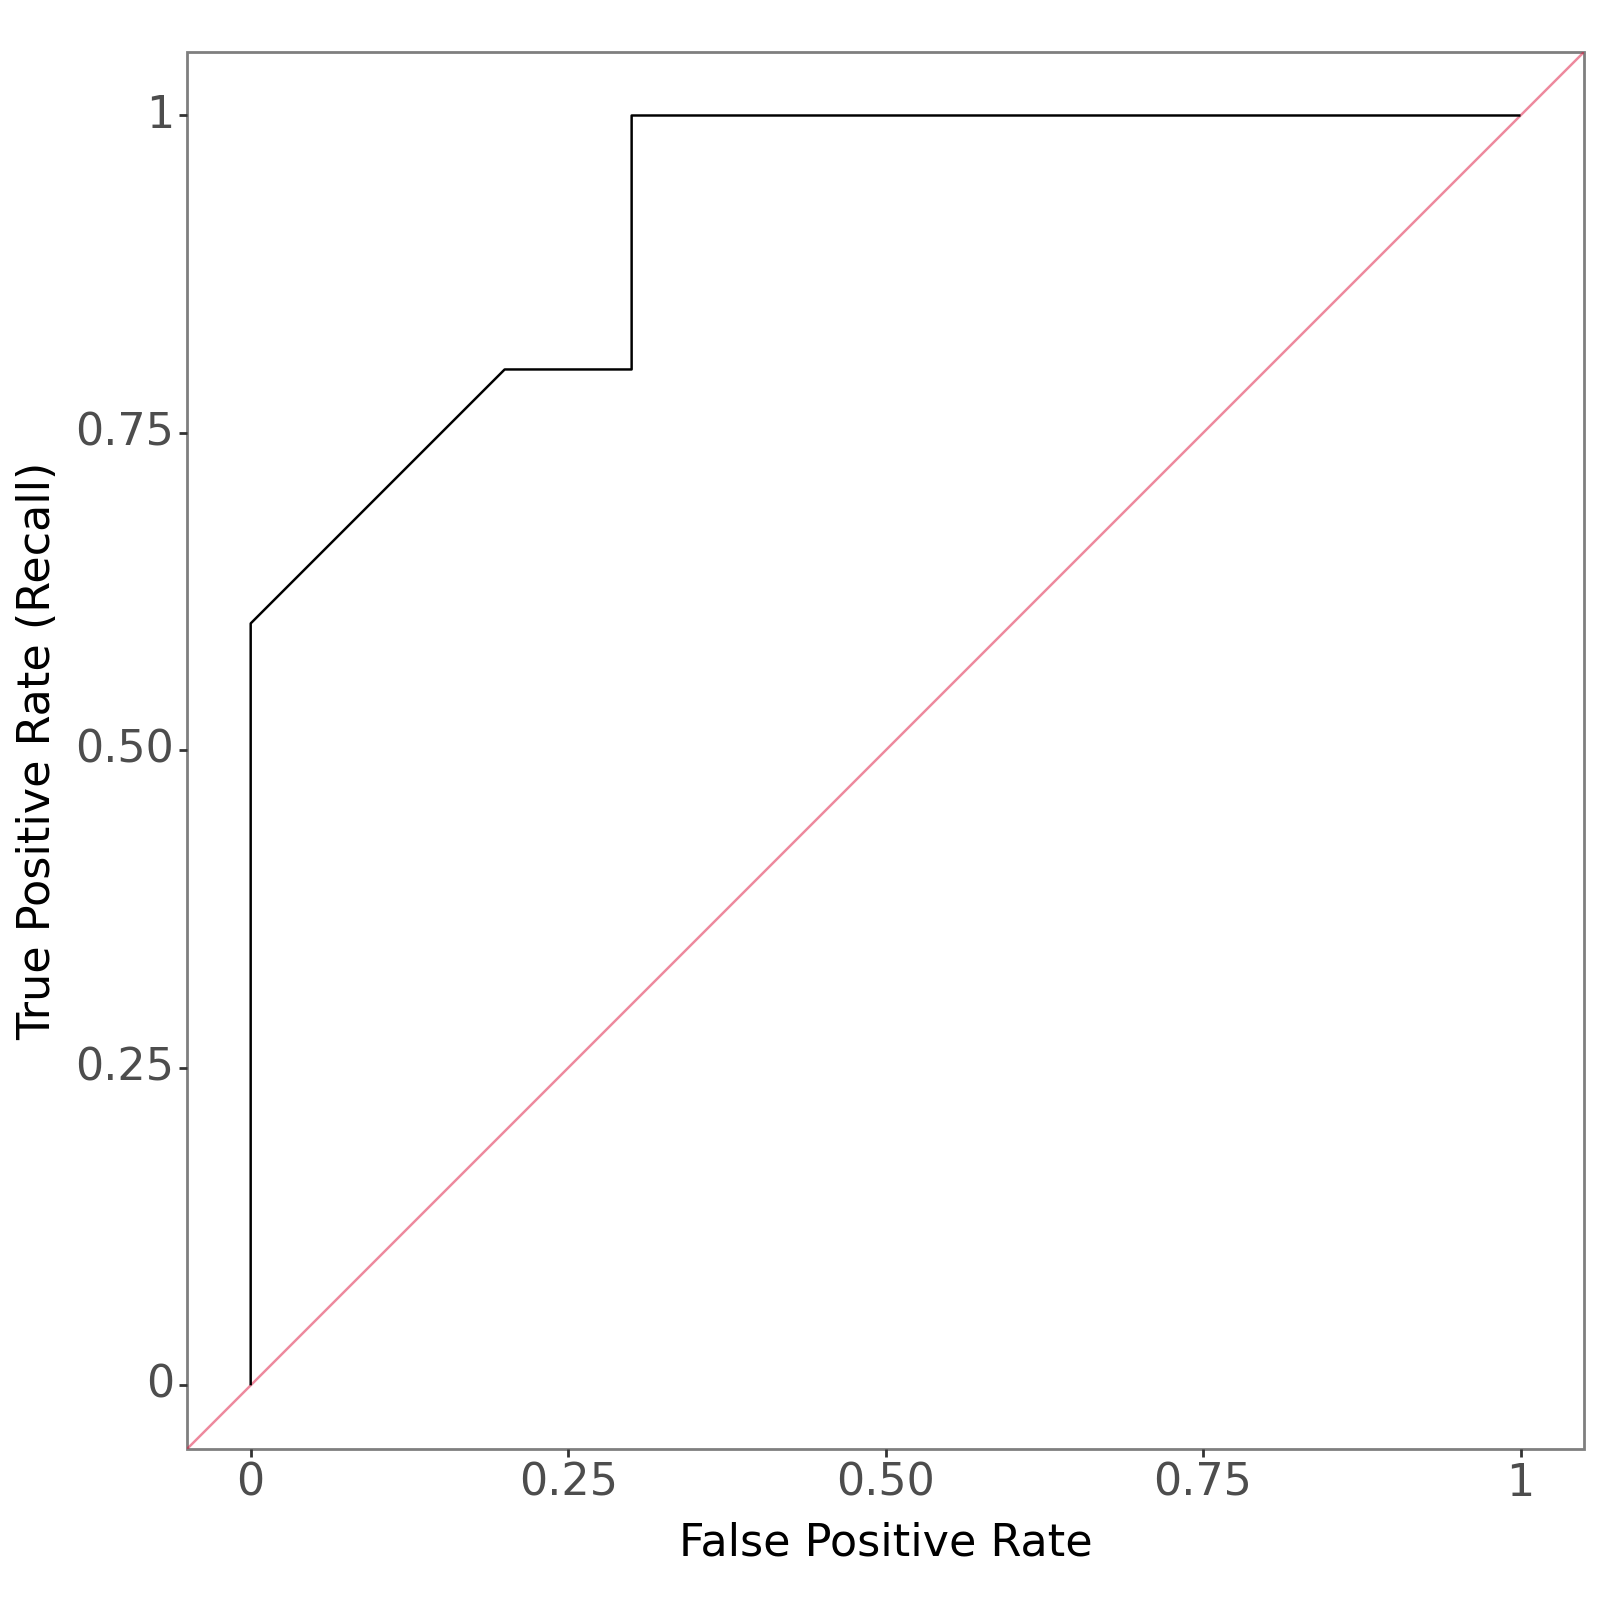

<Figure Size: (800 x 800)>

In [ ]:
(
    ggplot(roc, aes(x='fpr', y = 'tpr')) +
      geom_abline(intercept = 0, slope = 1, color = 'crimson', alpha = 0.5) +
      geom_line() +
      my_theme(figure_size = [8, 8]) +
      coord_equal() +
      labs(x = 'False Positive Rate', y = 'True Positive Rate (Recall)')
)

This code plots an ROC curve with shaded areas under the curve. The diagonal line shows random guessing, the polygons highlight the area under the ROC, and a text label displays the AUROC value. A custom theme is applied for a clean, square plot.

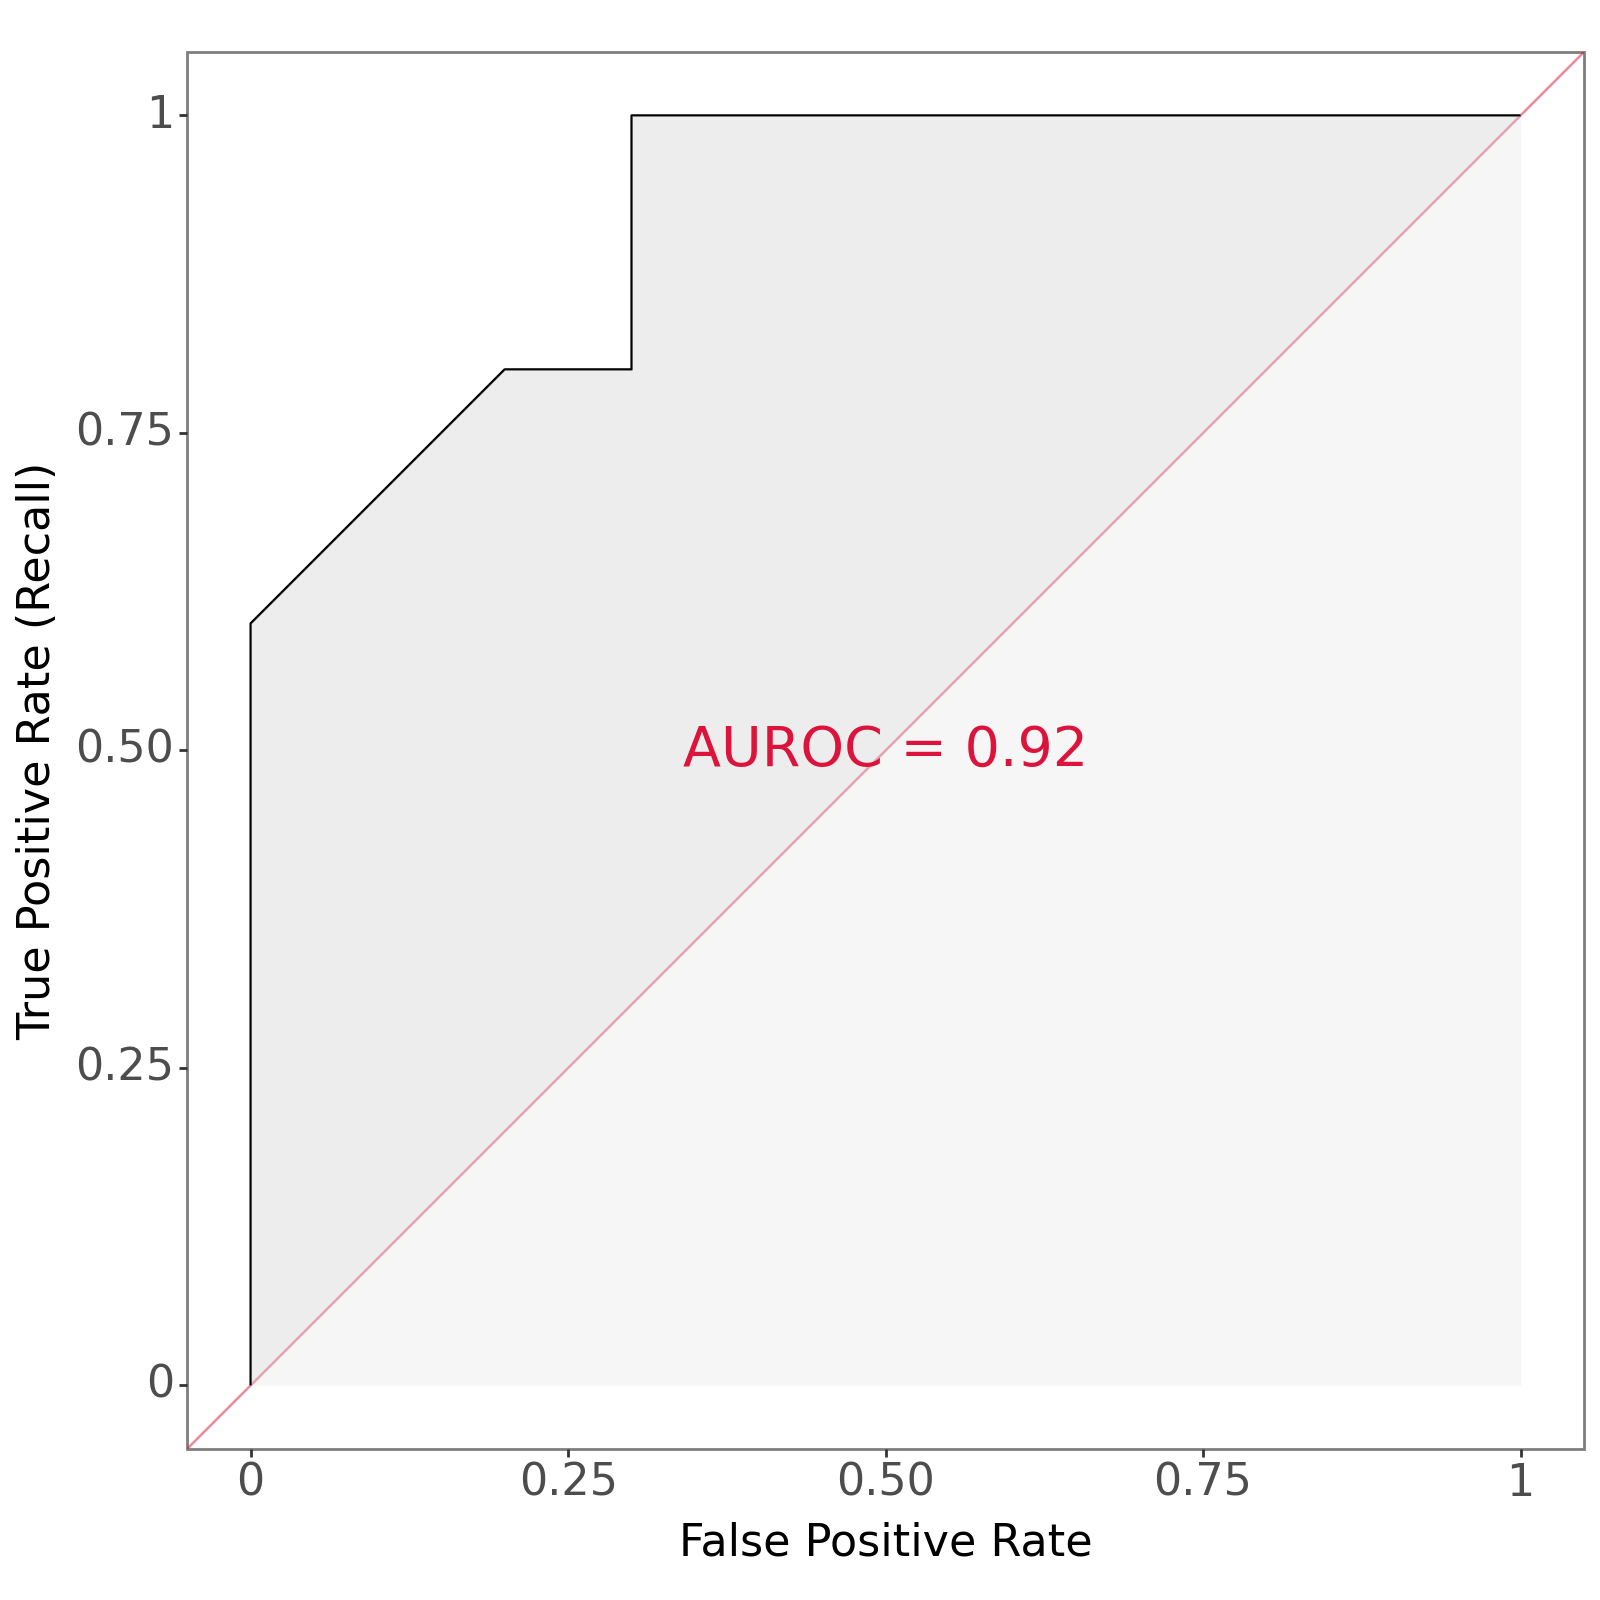

<Figure Size: (800 x 800)>

In [ ]:
roc_poly = roc.copy()
roc_poly.sort_values(['fpr', 'tpr'], inplace = True)
roc_poly_lower = pd.DataFrame({
    'fpr': [0., 1., 1.],
    'tpr': [0., 1., 0.]
})

aucroc_label = pd.DataFrame({
  'fpr': [0.5],
  'tpr': [0.5],
  'label': 'AUROC = ' + '{:.2f}'.format(auc)
})

(
    ggplot(roc, aes(x='fpr', y = 'tpr')) +
      geom_abline(intercept = 0, slope = 1, color = 'crimson', alpha = 0.5) +
      geom_line() +
      geom_polygon(
          aes(x = 'fpr', y = 'tpr'),
          data = roc_poly, fill = 'lightgray', alpha = 0.4) +
      geom_polygon(
          aes(x = 'fpr', y = 'tpr'),
          data = roc_poly_lower, fill = 'lightgray', alpha = 0.2) +
      geom_text(
          aes(label = 'label'),
          data = aucroc_label, color = 'crimson', size = 20) +
      my_theme(figure_size = [8, 8]) +
      coord_equal() +
      labs(x = 'False Positive Rate', y = 'True Positive Rate (Recall)')
)